# Машинное обучение
## ВМК МГУ, весна 2015/2016
## Лабораторная работа 1. Линейные модели

ФИО: Никишин Евгений Сергеевич

Группа: 317

Данное задание посвящено применению линейных моделей в задачах классификации и регрессии. Вы научитесь:
* делать one-hot-кодирование категориальных признаков
* обучать логистическую и линейную регрессию
* отбирать признаки с помощью LASSO
* вычислять метрики качества классификации и регрессии
* выбирать лучший классификатор при ограничениях на точность или полноту
* калибровать вероятности
* реализовывать градиентный спуск (если захотите)


In [246]:
import numpy as np
import pandas as pd
%matplotlib inline

## Часть 1. Научные гранты в Австралии

![](http://imgur.com/cBdDBO3.jpg)

В данной части мы будем работать с задачей "Predict Grant Applications" (https://www.kaggle.com/c/unimelb/data), где для заявки на грант требуется предсказать, одобрят её или нет. Будем использовать лишь 40 признаков из имеющихся 249. Файлы для работы можно найти по ссылкам:
* https://db.tt/iYzRzQYP (обучение)
* https://db.tt/NGSHb5Qs (контроль)

#### Задание 1
Считайте обучающую и контрольную выборки из файлов с помощью pd.read_csv. Выделите целевую переменную (Grant.Status) в отдельный вектор.

In [247]:
data_train = pd.read_csv('./unimel_train.csv')
target_train = data_train['Grant.Status']
data_train.drop(['Grant.Status'], axis=1, inplace=True)

data_test = pd.read_csv('./unimel_test.csv')
target_test = data_test['Grant.Status']
data_test.drop(['Grant.Status'], axis=1, inplace=True)

#### Задание 2
В этом задании мы приведем данные к виду, пригодному для обучения линейных классификаторов. Для этого вещественные признаки надо отмасштабировать, а категориальные — привести к числовому виду. Также надо устранить пропуски в данных.

В первую очередь поймем, зачем здесь нужно масштабирование. Нарисуем распределение трех признаков.

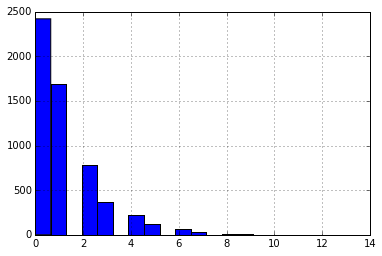

In [248]:
data_train['Number.of.Successful.Grant.1'].hist(bins=20)

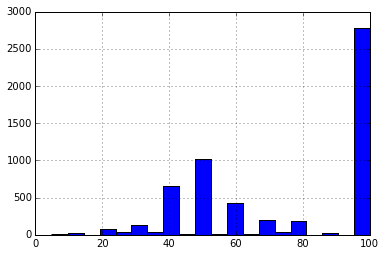

In [249]:
data_train['RFCD.Percentage.1'].hist(bins=20)

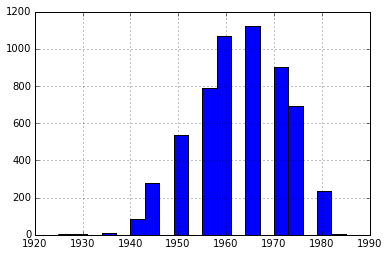

In [250]:
data_train['Year.of.Birth.1'].hist(bins=20)

Какую проблему вы наблюдаете на этих графиках? Как масштабирование поможет её исправить?

##### Ответ: Данные имеют разные диапазоны изменения, поэтому будет хорошо их отмасштабировать, так как линейные классификаторы чувствительны к масштабам

В наших данных есть пропуски. Ответьте на вопросы:
1. Сколько всего пропущенных элементов в таблице с обучающей выборкой?
2. Сколько объектов имеют хотя бы один пропуск?
3. Сколько признаков имеют хотя бы одно пропущенное значение?

##### Ответ 1: всего пропущенных элементов

In [251]:
np.sum(np.sum(data_train.isnull()))

26843

##### Ответ 2: всего объектов имеют хотя бы один пропуск

In [252]:
np.sum(np.sum(data_train.isnull(), axis=1) != 0)

5879

##### Ответ 3: всего признаков имеют хотя бы один пропуск

In [253]:
np.sum(np.sum(data_train.isnull(), axis=0) != 0)

38

Большинство признаков в нашем датасете являются категориальными. Типичным подходом к работе с ними является бинарное, или one-hot-кодирование (также есть подход со счётчиками, который мы уже применяли в прошлых работах). Для начала потренируемся делать бинарное кодирование на трех игрушечных объектах.

In [254]:
simple_data = pd.DataFrame({'City': ['Msk', 'SPb', 'Msk'], 'Weather': ['good', 'bad', 'worst']})
simple_data.head()

,City,Weather
0,Msk,good
1,SPb,bad
2,Msk,worst


In [255]:
# преобразуем каждый объект в dict
simple_data_dict = simple_data.T.to_dict().values()
print simple_data_dict

[{'City': 'Msk', 'Weather': 'good'}, {'City': 'SPb', 'Weather': 'bad'}, {'City': 'Msk', 'Weather': 'worst'}]


In [256]:
# делаем one-hot-кодирование
from sklearn.feature_extraction import DictVectorizer
transformer = DictVectorizer(sparse=False)
# примените здесь DictVectorizer к simple_data_dict, получите бинарную матрицу и выведите её
print transformer.fit_transform(simple_data_dict).astype(int)

[[1 0 0 1 0]
 [0 1 1 0 0]
 [1 0 0 0 1]]


Реализуйте функцию transform_data, которая принимает на вход DataFrame с признаками, объекты классов StandardScaler и DictVectorizer и булеву переменную is_test (True, если обрабатывает тестовую выборку и False, если обучающую). В функции должны выполняться следующие шаги:
1. Замена пропущенных значений на нули для вещественных признаков и на строки 'nan' для категориальных. Используйте для выполнения замены функцию fillna. Имена всех вещественных переменных перечислены в numeric_cols.
2. Масштабирование вещественных признаков с помощью StandardScaler (метод fit_transform, если is_test == False, и метод transform в противном случае).
3. One-hot-кодирование категориальных признаков с помощью DictVectorizer (метод fit_transform, если is_test == False, и метод transform в противном случае).

Метод должен возвращать tuple из трех элементов: преобразованной выборки, объекта StandardScaler и объекта DictVectorizer. Преобразованная выборка должна состоять из масштабированных вещественных признаков и закодированных категориальных (исходные признаки не должны в ней остаться).

In [257]:
def transform_data(data, scaler, transformer, is_test):
    numeric_cols = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                    'RFCD.Percentage.4', 'RFCD.Percentage.5',
                    'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                    'SEO.Percentage.4', 'SEO.Percentage.5',
                    'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1']
    
    categorical_cols = list(set(data.columns) - set(numeric_cols))
    
    new_data = data.copy()
    new_data[numeric_cols] = new_data.fillna(0)[numeric_cols]
    new_data[categorical_cols] = new_data.fillna('nan')[categorical_cols].astype('str')
    
    categorical_data_dict = new_data[categorical_cols].T.to_dict().values()
    
    if is_test:
        new_data[numeric_cols] = scaler.transform(new_data[numeric_cols])
        hot_coded_data = transformer.transform(categorical_data_dict)
    else:
        new_data[numeric_cols] = scaler.fit_transform(new_data[numeric_cols])
        hot_coded_data = transformer.fit_transform(categorical_data_dict)
    
    
    new_data.drop(categorical_cols, axis=1, inplace=True)
    new_data = new_data.as_matrix()
    new_data = np.hstack((new_data, hot_coded_data))
    
    return new_data, scaler, transformer

Применяем функцию к данным:

In [258]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
transformer = DictVectorizer(sparse=False)
X, scaler, transformer = transform_data(data_train, scaler, transformer, False)
X_test, _, _ = transform_data(data_test, scaler, transformer, True)

Сколько признаков у вас получилось после преобразования?

In [259]:
print X.shape[1]

11734


#### Задание 3
Подберите лучшее значение параметра регуляризации C для логистической регрессии с L2-регуляризатором (sklearn.linear_model.LogisticRegression) с помощью кросс-валидации по 5 блокам. В качестве метрики качества используйте AUC-ROC. Сетка для перебора указана ниже. По итогам кросс-валидации укажите лучшее значение параметра регуляризации. Обучите классификатор с этим параметром на всей обучающей выборке и найдите качество (AUC-ROC) на тестовой выборке.

In [260]:
from sklearn.cross_validation import KFold
cv = KFold(X.shape[0], n_folds=5, shuffle=True, random_state=241)
y, y_test = target_train.as_matrix(), target_test.as_matrix()

In [261]:
# вам пригодятся функции cross_val_score или GridSearchCV; используйте в них объект cv в качестве генератора разбиений
C_grid = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
params = {'C': C_grid}

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(n_jobs=-1)

from sklearn.grid_search import GridSearchCV
grid = GridSearchCV(clf, params, scoring='roc_auc', cv=cv)

In [263]:
grid.fit(X, y)
print 'Best score is:', round(grid.best_score_, 4), 'with', grid.best_params_

Best score is: 0.8824 with {'C': 0.1}


In [264]:
from sklearn.metrics import roc_auc_score
clf_best = LogisticRegression(C=0.1, n_jobs=-1)
clf_best.fit(X, y)
preds = clf_best.predict_proba(X_test)[:, 1]
print 'Score for test is', round(roc_auc_score(y_test, preds), 4)

Score for test is 0.8803


Попробуем теперь логистическую регрессию с L1-регуляризатором (penalty='l1'). Выведите число ненулевых коэффициентов (clf.coef\_) при каждом значении параметра регуляризации из сетки.

In [265]:
for C in C_grid:
    clf = LogisticRegression(C=C, penalty='l1', n_jobs=-1)
    clf.fit(X, y)
    print 'There are', np.sum(np.logical_not(np.isclose(clf.coef_, 0))), 'non-zero coefficients with C =', C

There are 0 non-zero coefficients with C = 0.001
There are 9 non-zero coefficients with C = 0.01
There are 58 non-zero coefficients with C = 0.1
There are 667 non-zero coefficients with C = 1.0
There are 2434 non-zero coefficients with C = 10.0
There are 2966 non-zero coefficients with C = 100.0


Какое качество на тесте даёт логистическая регрессия с L1-регуляризатором с параметром C=0.01? Сколько для достижения такого качества ей нужно признаков?

In [266]:
clf = LogisticRegression(C=0.01, penalty='l1', n_jobs=-1)
clf.fit(X, y)
print 'LogReg with C = 0.01 has quality', round(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]), 4), 
print 'and', np.sum(np.logical_not(np.isclose(clf.coef_, 0))), 'non-zero features' 

LogReg with C = 0.01 has quality 0.8525 and 8 non-zero features


##### Всего 9 признаков позволяют добиться такого качества. Круто!

#### Задание 4
В этом задании мы внимательно рассмотрим различные аспекты качества классификатора. Для этого возьмите классификатор с L2-регуляризатором с лучшим значением параметра регуляризации (вы его нашли в предыдущем задании), обучите на полной обучающей выборке и найдите предсказания вероятностей на тесте. Далее будем работать только с этими прогнозами.

In [267]:
clf = LogisticRegression(C=0.1, penalty='l2', n_jobs=-1)
clf.fit(X, y)
preds = clf.predict_proba(X_test)[:, 1]

Посчитайте AUC-ROC, AUC-PR (average_precision_score) и log-loss для прогнозов.

In [268]:
from sklearn.metrics import average_precision_score, log_loss
print 'AUC-ROC:', roc_auc_score(y_test, preds)
print 'AUC-PR:', average_precision_score(y_test, preds)
print 'log-loss:', log_loss(y_test, preds)

AUC-ROC: 0.880344342415
AUC-PR: 0.838753258274
log-loss: 0.44273695384


Нарисуйте ROC- и PR-кривые. Не забудьте подписать оси.

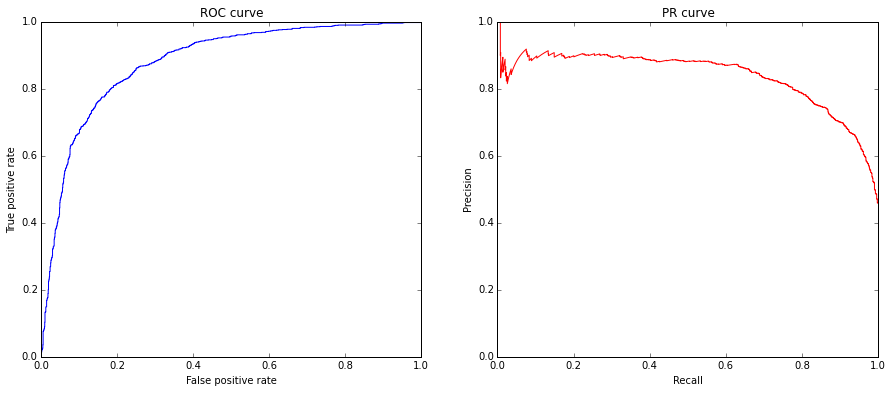

In [269]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve

fpr, tpr, _ = roc_curve(y_test, preds)
precision, recall, _ = precision_recall_curve(y_test, preds)

plt.figure(figsize=(15, 6))

plt.subplot(121)
plt.plot(fpr, tpr, c='b')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

plt.subplot(122)
plt.plot(recall, precision, c='r')
plt.ylim(0, 1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve')

plt.show()

Допустим, мы хотим построить классификатор, который будет находить не менее 90% успешных грантов. Соответственно, имеем нижнюю границу 90% на полноту. Какую максимальную точность при этом можно получить? При каком значении порога? Для получения ответа проанализируйте массивы, возвращаемые функцией metrics.precision_recall_curve.

In [270]:
print 'Maximum precision is', np.max(precision[recall > 0.9])
print 'with corresponding recall', recall[np.isclose(precision, np.max(precision[recall > 0.9]))][0]

Maximum precision is 0.701948051948
with corresponding recall 0.900083263947


Возьмите классификатор с порогом из предыдущего пункта и подсчитайте для него F-меру. Почему она получилась маленькой, несмотря на высокую полноту?

In [271]:
def f_score(pr, rec):
    return 2 * pr * rec / (pr + rec)
print 'F-score is', f_score(np.max(precision[recall > 0.9]), 
                            recall[np.isclose(precision, np.max(precision[recall > 0.9]))][0])

F-score is 0.7887632251


Допустим, что университету важно подавать как можно меньше заявок, которые окажутся неуспешными — они очень плохо влияют на репутацию. Установим нижнюю границу на точность 80%. Какую максимальную полноту при этом можно обеспечить? При каком пороге?

In [272]:
print 'Maximum recall is', np.max(recall[precision > 0.8])
print 'with corresponding precision', 
print precision[np.isclose(recall, np.max(recall[precision > 0.8]))][2] # a few precisions corresponds to that recall

Maximum recall is 0.776019983347
with corresponding precision 0.8


#### Задание 5
В этом задании мы научимся оценивать способность классификатора предсказывать вероятности, а также разберемся с калибровкой.

Начнем с калибровочных кривых. Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [337]:
def draw_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 20
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.figure(figsize=(6, 6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.plot([0, 1], [0, np.max(bin_real_ratios)], 'k:')

Проверим её работу на логистической регрессии (поменяйте имена переменных, если это необходимо). Получилась ли почти диагональная калибровочная кривая?

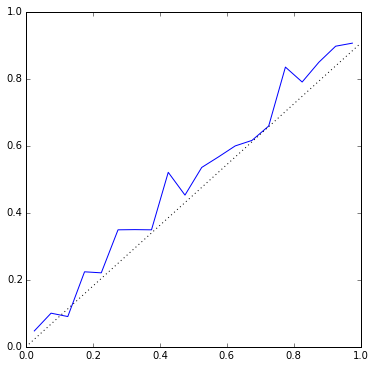

In [339]:
clf = LogisticRegression(C=1.0)
clf.fit(X, y)
preds = clf.predict_proba(X_test)[:, 1]
draw_calibration_curve(y_test, preds)

Заодно обратим внимание на то, как часто классификатор выдает те или иные вероятности.

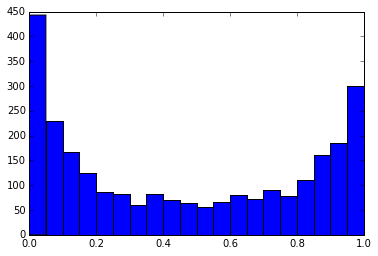

In [340]:
plt.hist(preds, bins=20)
plt.show()

Обучим теперь классификатор с кусочно-линейной функцией потерь (hinge loss, как в SVM).

In [343]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='hinge')
clf.fit(X, y)
preds = clf.decision_function(X_test)
preds = 1.0 / (1.0 + np.exp(-preds))

Изучите распределение ответов классификатора. Чем оно отличается от распределения у логистической регрессии? Чем вы можете объяснить это?

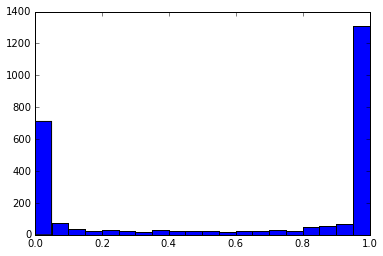

In [344]:
plt.hist(preds, bins=20)
plt.show()

##### Ответ: распределение этих ответов более "категорично", т.е. почти не допускает значений между 0 и 1. Объясняется это применённой функцией потерь: hinge loss не гладкая, по сравнению с функцией потерь, соответствущей логистической регрессии ( $\log(1+e^{-M})$ )

Нарисуем калибровочную кривую. Видите ли вы какие-либо проблемы в ней?

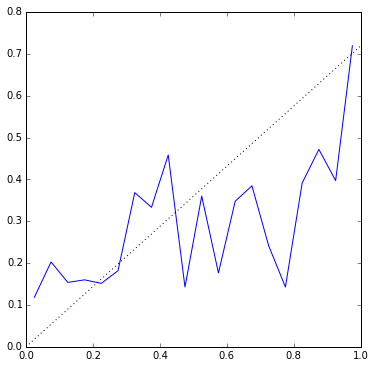

In [345]:
draw_calibration_curve(y_test, preds)

##### Ответ: Она совсем не похожа на диагональную

Попробуем откалибровать вероятности. Грубо говоря, это процедура, которая для каждого отрезка $[a_i, b_i]$ строит преобразование, которое корректирует вероятности в нем, приводя тем самым калибровочную кривую к диагональной форме.

Воспользуйтесь классом sklearn.calibration.CalibratedClassifierCV для калибровки вероятностей на обучении, и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

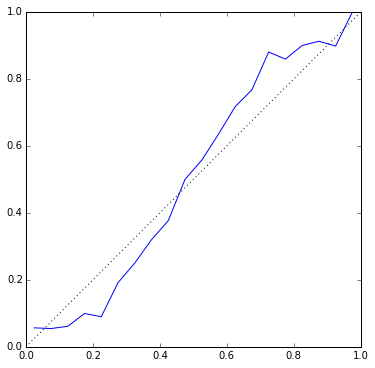

In [360]:
from sklearn.calibration import CalibratedClassifierCV
clf_calibrated = CalibratedClassifierCV(clf)
clf_calibrated.fit(X, y)
preds = clf_calibrated.predict_proba(X_test)[:, 1]
draw_calibration_curve(y_test, preds)

#### Задание 6
Здесь вы можете вставить вашу любимую картинку про Австралию.

<img src="http://ru.fishki.net/picsw/032013/07/post/ozero/tn.jpg">

## Часть 2. Градиентный спуск своими руками
**(опциональная часть, за правильное выполнение к оценке добавляется 3 балла)**

В этой части вам предстоит самостоятельно реализовать градиентный спуск для логистической функции потерь — то есть, по сути, собственными руками обучить логистическую регрессию. Будем использовать данные из предыдущей части.

Добавьте к обучающей и тестовой выборкам единичный признак. Переведите значения целевого вектора в множество $\{-1, +1\}$.

In [35]:
X = np.hstack((np.ones((X.shape[0], 1)), X))
X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))
y[y == 0] = -1
y_test[y_test == 0] = -1

Для начала реализуйте функции, которые вычисляют функционал, его градиент, а также прогнозы модели.

In [36]:
# возвращает вектор предсказанных вероятностей для выборки X
def make_pred(X, w):
    z = np.dot(X, w)
    return 1. / (1 + np.exp(-z))

In [37]:
# возвращает значение логистического функционала для выборки (X, y) и вектора весов w
def get_func(w, X, y):
    M = y * np.dot(X, w)
    return np.sum(np.log(1 + np.exp(-M))) / X.shape[0]

In [137]:
# возвращает градиент логистического функционала для выборки (X, y) и вектора весов w
def get_grad(w, X, y):
    M = (y * np.dot(X, w))[:, np.newaxis]
    grad = (-y[:, np.newaxis] * X * np.exp(-M)) / (1 + np.exp(-M))
    return np.sum(grad, axis=0) / X.shape[0]

Теперь реализуйте градиентный спуск (не стохастический). Функция должна возвращать вектор весов и список значений функционала на каждой итерации. В градиентном спуске должно выполняться не более max_iter итераций.

In [54]:
def grad_descent(X, y, step_size, max_iter):
    convergence = False
    iteration = 0
    tol = 1e-3
    func_values = []
    w = np.random.rand(X.shape[1])
    
    while not convergence and iteration < max_iter:
        iteration += 1
        w -= step_size * get_grad(w, X, y)
        func_values.append(get_func(w, X, y))
        
        if len(func_values) > 1:
            if np.abs(func_values[-1] - func_values[-2]) < tol:
                convergence = True
        
    return w, func_values

Запустите градиентный спуск для значений размера шага из набора [0.001, 1, 10]. Нарисуйте кривые зависимости значения функционала от номера итерации. Проанализируйте их. Вычислите AUC-ROC на тестовой выборке для лучшего из обученных вариантов.

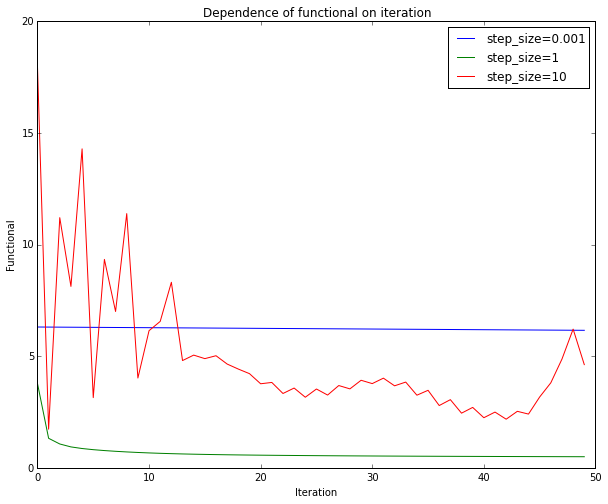

In [55]:
step_list = [0.001, 1, 10]
plt.figure(figsize=(10, 8))
w_list = []

for step_size in step_list:
    w, func_values = grad_descent(X, y, step_size=step_size, max_iter=50)
    
    plt.plot(func_values, label='step_size=' + str(step_size))
    w_list.append(w)
    
plt.xlabel('Iteration')
plt.ylabel('Functional')
plt.title('Dependence of functional on iteration')
plt.legend(loc='best')
plt.show()

##### Видно, что размер шага 1 оптимален, в то время как при 10 функционал расходится, а при 0.001 сходится, но слишком медленно

In [72]:
roc_auc_score(y_test, make_pred(X_test, w_list[1]))

0.83272526671588598

Теперь реализуйте стохастический градиентный спуск. Функция должна возвращать вектор весов и список значений функционала на каждой итерации. В стохастическом градиентном спуске должно выполняться не более max_iter итераций.

In [211]:
def sgd(X, y, step_size, max_iter):
    convergence = False
    iteration = 0
    tol = 1e-7
    func_values = []
    lambda_ = 0.05
    
    w = np.random.rand(X.shape[1])
    Q_approx = get_func(w, X, y)
    
    while not convergence and iteration < max_iter:
        iteration += 1
        sample = np.random.randint(0, X.shape[0])
        w -= step_size * get_grad(w, X[sample][np.newaxis, :], y[sample][np.newaxis])
        Q_approx = (1 - lambda_) * Q_approx + lambda_ * get_func(w, X[sample][np.newaxis, :], y[sample][np.newaxis])
        func_values.append(Q_approx)
        
        if len(func_values) > 1:
            if np.abs(func_values[-1] - func_values[-2]) < tol:
                convergence = True
        
    return w, func_values

Подберите размер шага, при котором SGD будет сходиться. Нарисуйте график сходимости. Вычислите AUC-ROC на тестовой выборке.

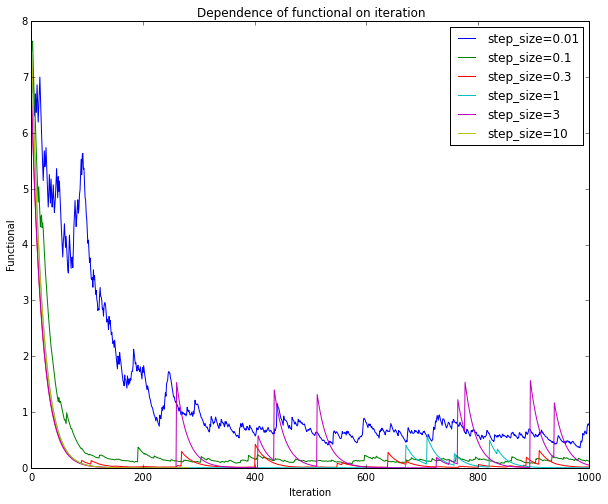

In [212]:
step_list = [0.01, 0.1, 0.3, 1, 3, 10]
plt.figure(figsize=(10, 8))
w_list = []

for step_size in step_list:
    w, func_values = sgd(X, y, step_size=step_size, max_iter=1000)
    
    plt.plot(func_values, label='step_size=' + str(step_size))
    w_list.append(w)
    
plt.xlabel('Iteration')
plt.ylabel('Functional')
plt.title('Dependence of functional on iteration')
plt.legend(loc='best')
plt.show()

##### Пожалуй, лучший размер шага -- 0.3 (однако это очень сильно зависит от параметров, таких как толерантность, темп забывания).
##### P.S. алгоритм брал из [соответствующей лекции Воронцова](http://www.machinelearning.ru/wiki/images/5/53/Voron-ML-Lin-SG.pdf#11)

In [217]:
roc_auc_score(y_test, make_pred(X_test, w_list[2]))

0.81775220366408552

А теперь самое сложное: заново сформируйте выборку с помощью transform_data, но теперь не масштабируйте вещественные признаки. Запустите на этой выборке градиентный спуск. Что вы наблюдаете? Удается ли достичь такого же качества, как и при использовании масштабирования?

In [218]:
def transform_without_scaling(data, scaler, transformer, is_test):
    numeric_cols = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                    'RFCD.Percentage.4', 'RFCD.Percentage.5',
                    'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                    'SEO.Percentage.4', 'SEO.Percentage.5',
                    'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1']
    
    categorical_cols = list(set(data.columns) - set(numeric_cols))
    
    new_data = data.copy()
    new_data[numeric_cols] = new_data.fillna(0)[numeric_cols]
    new_data[categorical_cols] = new_data.fillna('nan')[categorical_cols].astype('str')
    
    categorical_data_dict = new_data[categorical_cols].T.to_dict().values()
    
    if is_test:
        #new_data[numeric_cols] = scaler.transform(new_data[numeric_cols])
        hot_coded_data = transformer.transform(categorical_data_dict)
    else:
        #new_data[numeric_cols] = scaler.fit_transform(new_data[numeric_cols])
        hot_coded_data = transformer.fit_transform(categorical_data_dict)
    
    
    new_data.drop(categorical_cols, axis=1, inplace=True)
    new_data = new_data.as_matrix()
    new_data = np.hstack((new_data, hot_coded_data))
    
    return new_data, scaler, transformer

In [219]:
X, scaler, transformer = transform_without_scaling(data_train, scaler, transformer, False)
X_test, _, _ = transform_without_scaling(data_test, scaler, transformer, True)

X = np.hstack((np.ones((X.shape[0], 1)), X))
X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

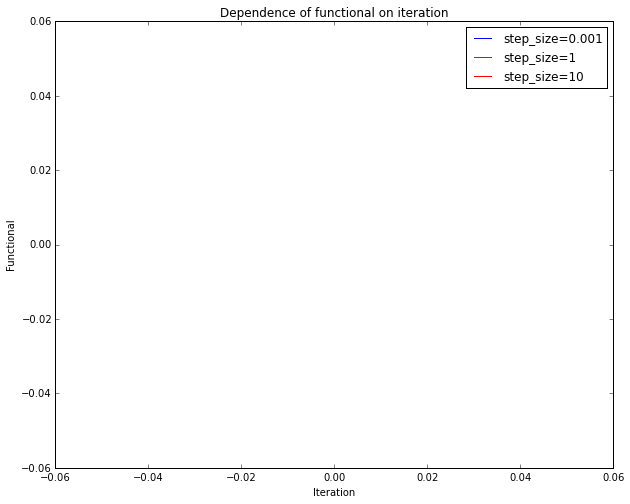

In [220]:
step_list = [0.1, 0.3, 1, 3]
plt.figure(figsize=(10, 8))
w_list = []

for step_size in step_list:
    w, func_values = grad_descent(X, y, step_size=step_size, max_iter=50)
    
    plt.plot(func_values, label='step_size=' + str(step_size))
    w_list.append(w)
    
plt.xlabel('Iteration')
plt.ylabel('Functional')
plt.title('Dependence of functional on iteration')
plt.legend(loc='best')
plt.show()

In [226]:
func_values[:10]

[inf, nan, nan, nan, nan, nan, nan, nan, nan, nan]

In [224]:
roc_auc_score(y_test, make_pred(X_test, w_list[2]))

0.48519293412241449

##### Aлгоритм вообще не работает без скейла

Здесь вы можете поделиться своими мыслями по поводу этой части.

## Часть 3. Линейная регрессия на простом примере

В этой части мы очень кратко разберемся с линейной регрессией и измерением качества ее прогнозов. Будем использовать датасет diabetes.

In [227]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
data = datasets.load_diabetes()
X, X_test, y, y_test = train_test_split(data.data, data.target, train_size=0.7, random_state=241)

Обучите линейную регрессию с L2-регуляризатором, подобрав лучшее значение параметра регуляризации на тестовой выборке. Используйте MSE в качестве тестовой выборки. При каком значении этого параметра достигается наилучшее качество?

In [233]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
alpha_grid = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

for alpha in alpha_grid:
    clf = Ridge(alpha)
    clf.fit(X, y)
    preds = clf.predict(X_test)
    print 'Alpha:', alpha, 'MSE:', round(mean_squared_error(y_test, preds), 1)

Alpha: 0.001 MSE: 3120.1
Alpha: 0.01 MSE: 3107.4
Alpha: 0.1 MSE: 3096.0
Alpha: 1.0 MSE: 3399.4
Alpha: 10.0 MSE: 4577.5
Alpha: 100.0 MSE: 5210.2


##### Ответ: при alpha = 0.1

Вычислите для лучшей из моделей RMSE и коэффициент детерминации (r2_score) на тестовой выборке. Что вы можете сказать о значении коэффицинта детерминации? Насколько данная модель близка к оптимальной?

In [235]:
from sklearn.metrics import r2_score

clf = Ridge(0.1)
clf.fit(X, y)
preds = clf.predict(X_test)
print 'RMSE:', np.sqrt(mean_squared_error(y_test, preds))
print 'Determination coefficient:', r2_score(y_test, preds)

RMSE: 55.6419819113
Determination coefficient: 0.417024184822


##### Коэффициент детерминизации равен 1 для оптимальной модели и равен 0 для модели, выдающей константу (среднее значение целевой функции). Таким образом, модель не так хороша (оно и ожидаемо: RMSE = 55 при ответах в диапазоне (30, 350) есть достаточно много)